# Exercice 1 : Stationary Environment - Multi Armed Bandits

In [1]:
import os
os.chdir("../")

In [2]:
import numpy as np
import tensorflow as tf
from tqdm import trange
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ENV.Stationary_Bandit_ENV as S_bandit_env
from ENV.Logger import Logger
import math
np.random.seed(42) # For reproductibility

In [3]:
os.getcwd()

'/code/reinforcement_learning/Tutorial_HEC/Labs'

# $\epsilon-greedy$ action value ( sample average)

In [4]:
# Creating the environment 
env = S_bandit_env.Stationary_Bandit()

env.get_nb_bandit
env.list_mean_bandit()

Bandit : 0  has a mean of  0.9934283060224653  and a sigma of 1
Bandit : 1  has a mean of  0.2765286023423693  and a sigma of 1
Bandit : 2  has a mean of  1.295377076201385  and a sigma of 1
Bandit : 3  has a mean of  3.0460597128160507  and a sigma of 1
Bandit : 4  has a mean of  0.46830674944667194  and a sigma of 1
Bandit : 5  has a mean of  0.4682739138983611  and a sigma of 1
Bandit : 6  has a mean of  3.158425631014783  and a sigma of 1
Bandit : 7  has a mean of  1.5348694583058176  and a sigma of 1
Bandit : 8  has a mean of  0.9389487718699042  and a sigma of 1
Bandit : 9  has a mean of  1.0851200871719293  and a sigma of 1


In [5]:
class Q_solver() :

    def __init__(self, env, timestep = 1000) :
        self.env = env
        self.nb_bandits = env.get_nb_bandit
        self.Q_table = np.zeros((self.nb_bandits, 1))
        self.action_count = np.zeros((self.nb_bandits, 1))
        self.timestep = timestep
        # Parameters initialisation
        self.epsilon = 0.1
        self.print_delay = 0.25
        # Logger
        self.logger = Logger()

    def act(self, act_epsilon_greedy) :
        if act_epsilon_greedy :
            return np.random.randint(0, self.nb_bandits, 1)[0]  # Transform [Action] to action (int)
        else :
            return np.argmax(self.Q_table)

    def updateQtable(self, action, reward, action_count) :
        self.Q_table[action] = self.Q_table[action] + 1 / action_count * (reward - self.Q_table[action])

    def run(self, force_epsilon = None) :
        self.boxplotter = np.array([[0]] * self.nb_bandits).tolist()
        print(self.boxplotter)
        if force_epsilon is not None :
            self.epsilon = force_epsilon
        env.reset()
        cumul_reward = 0

        for iteration in trange(1, self.timestep) :
            action = self.act(self.epsilon > np.random.random())
            self.action_count[action] += 1
            reward = env.step(action)
            cumul_reward += reward
            self.boxplotter[action].append(reward)
            self.updateQtable(action, reward, self.action_count[action][0])
            self.logger.epsilon_log(self.epsilon)
            self.logger.reward_log(reward)
            if iteration % (self.timestep * self.print_delay) == 0 :
                self.logger.mean_reward_log(cumul_reward / (self.timestep * self.print_delay))
                self.logger.plot_log()
                cumul_reward = 0
                plt.boxplot(solver.boxplotter)
                plt.show()

In [6]:
env = S_bandit_env.Stationary_Bandit()
solver = Q_solver(env, 100000)

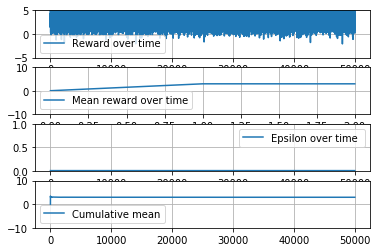

Maximum mean over time :  2.922484226141493


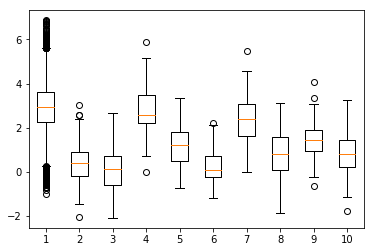

 51%|█████     | 51033/99999 [01:28<03:01, 269.43it/s]

KeyboardInterrupt: 

In [7]:

solver.run(0.01)

In [8]:
import seaborn as sns
solver.Q_table

array([[2.93517243],
       [0.3625723 ],
       [0.0966338 ],
       [2.87361786],
       [1.24318433],
       [0.23298745],
       [2.38401287],
       [0.77981994],
       [1.47605697],
       [0.82255775]])

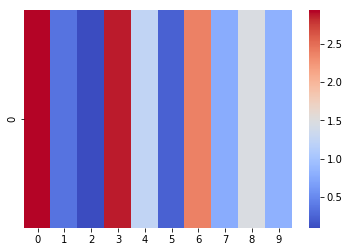

 51%|█████     | 51033/99999 [01:40<03:01, 269.43it/s]

In [9]:
sns.heatmap(solver.Q_table.T, cmap="coolwarm")

# UCB

In [10]:
class Q_solver_UCB(Q_solver) :

    def __init__(self, env, timestep = 1000) :
        Q_solver.__init__(self, env, timestep)
        self.c = 0.75
    def act(self, time, act_counter):
        maxer = []
        for action in range(self.nb_bandits):
            maxer.append(self.Q_table[action] + self.c * np.sqrt(math.log(time) / (1 + act_counter[action])))
        return np.argmax(maxer)
    
    def run(self, force_epsilon = None) :

        if force_epsilon is not None :
            self.epsilon = force_epsilon
        env.reset()
        cumul_reward = 0

        for iteration in trange(1, self.timestep) :
            action = self.act(iteration, self.action_count)
            self.action_count[action] += 1
            reward = env.step(action)
            cumul_reward += reward
            self.updateQtable(action, reward, self.action_count[action][0])
            self.logger.reward_log(reward)
            if iteration % (self.timestep * self.print_delay) == 0 :
                self.logger.mean_reward_log(cumul_reward / (self.timestep * self.print_delay))
                self.logger.plot_log(5)
                cumul_reward = 0


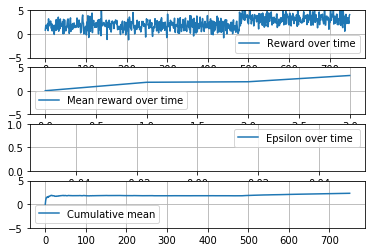

100%|██████████| 999/999 [00:03<00:00, 320.82it/s]

Maximum mean over time :  3.2172892476533526


In [11]:
env = S_bandit_env.Stationary_Bandit()
solver = Q_solver_UCB(env)

solver.run(0.01)

## Policy based : Gradient bandit

In [12]:
class Q_solver_policy(Q_solver) :

    def __init__(self, env, timestep = 1000) :
        Q_solver.__init__(self, env, timestep)
        self.alpha = 0.1

    def act(self, policy) :
        possible_actions = np.array(range(self.nb_bandits))
        return np.random.choice(possible_actions, size = 1, p = policy.flatten() / np.sum(policy))[0]

    def update_preferences(self, preferences, action, reward, mean_reward, policy) :
        preferences[action] += self.alpha * (reward - mean_reward) * (1 - policy[action])
        for act in range(self.nb_bandits) :
            if act != action :
                preferences[act] -= self.alpha * (reward - mean_reward) * policy[act]
        return preferences

    def compute_policy(self, preferences) :
        policy = np.exp(preferences) / np.sum(np.exp(preferences))
        return policy

    def run(self, force_epsilon = None) :
        self.boxplotter = [[0]] * self.nb_bandits
        env.reset()
        cumul_reward = 0
        preferences = np.zeros((self.nb_bandits, 1))
        average_reward = 0.0
        for iteration in trange(1, self.timestep) :
            policy = self.compute_policy(preferences)
            action = self.act(policy)
            reward = env.step(action)
            self.boxplotter[action].append(reward)
            self.logger.reward_log(reward)
            cumul_reward += reward
            average_reward += (reward - average_reward) / iteration
            preferences = self.update_preferences(preferences, action, reward, average_reward, policy)
            if iteration % (self.timestep * self.print_delay) == 0 :
                self.logger.plot_mean_reward()
                cumul_reward = 0


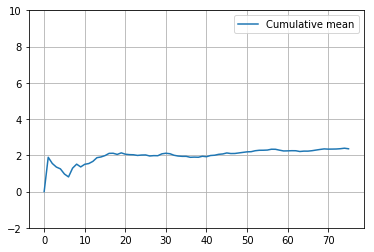

100%|██████████| 99/99 [00:01<00:00, 89.70it/s]


In [13]:
env = S_bandit_env.Stationary_Bandit()
solver = Q_solver_policy(env, timestep=100)
solver.run()

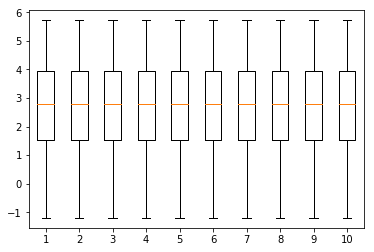

In [14]:
plt.boxplot(solver.boxplotter)
plt.show()

# Exercice 2 : Non-Stationary Environment - Multi Armed Bandits

In [15]:
import ENV.Non_Stationary_Bandit_ENV as NS_bandit_env


# Experiment last Solver 

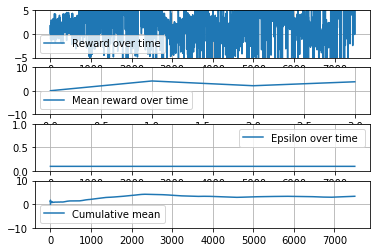

Maximum mean over time :  4.121847812995437


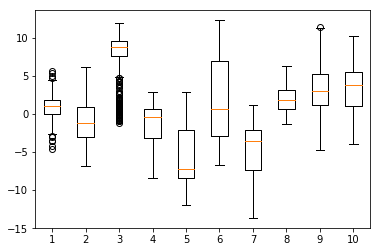

100%|██████████| 9999/9999 [00:08<00:00, 1189.18it/s]


In [16]:
env = NS_bandit_env.Non_Stationary_Bandit()
solver = Q_solver(env, 10000)
solver.run(0.1)

## Improvement 

In [17]:
class Q_solver_NS(Q_solver) :
    def __init__(self, env, timestep = 1000) :
        Q_solver.__init__(self, env, timestep)
        self.alpha = 0.1

    def updateQtable(self, action, reward, action_count) :
        self.Q_table[action] = self.Q_table[action] + self.alpha * (reward - self.Q_table[action])


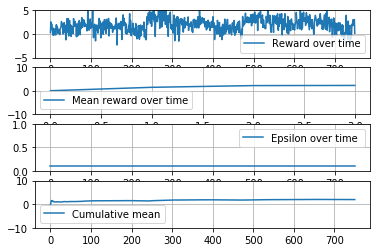

Maximum mean over time :  2.2282516545301885


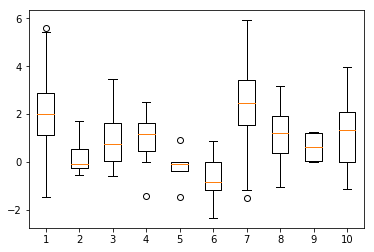

100%|██████████| 999/999 [00:04<00:00, 234.72it/s]


In [18]:
env = NS_bandit_env.Non_Stationary_Bandit()
solver = Q_solver_NS(env)
solver.run(0.1)


# Exercice 3 : Contextual Environment - Multi Armed Bandits

In [19]:
import ENV.ContextualBandit as C_Bandit

In [20]:
class Q_solver_contextual(Q_solver):
    
    def __init__(self, env, timestep = 1000):
        Q_solver.__init__(self, env, timestep)
        self.nb_context = env.get_nb_context 
        self.Q_table = np.zeros((self.nb_bandits, self.nb_context))
        self.action_count = np.zeros((self.nb_bandits, self.nb_context))
        self.timestep = timestep
        # Parameters initialisation        
        self.epsilon = 1.
        self.epsilon_origin = 1.
        self.epsilon_decay = 10
        self.epsilon_min = 0.02
        self.print_delay = 0.1
       
        
    def act(self, act_epsilon_greedy, context):
        if act_epsilon_greedy :
            return np.random.randint(0, self.nb_bandits, 1)[0]  # Transform [Action] to action (int)
        else:
            return np.argmax(self.Q_table, axis = 1)[context]
        
    def updateQtable(self, action, reward, action_count, context):
        self.Q_table[action][context] = \
                    self.Q_table[action][context] + 1 / action_count * (reward - self.Q_table[action][context])
                    
        
    def run(self, force_epsilon = None):
        context = env.reset()
        cumul_reward = 0
        self.boxplotter = [[0]] * self.nb_bandits
        for iteration in trange(1, self.timestep):
            action = self.act(self.epsilon > np.random.random(), context)
            self.action_count[action] += 1
            reward, context = env.step(action)
            self.updateQtable(action, reward, self.action_count[action][0], context)
            # Update epsilon with linear decay
            self.epsilon = max(self.epsilon - self.epsilon_origin / self.epsilon_decay, self.epsilon_min)
            if force_epsilon is not None:
                self.epsilon = force_epsilon
            self.boxplotter[action].append(reward)
            cumul_reward += reward
            self.logger.epsilon_log(self.epsilon)
            self.logger.reward_log(reward)
            if iteration % (self.timestep * self.print_delay) == 0 :
                self.logger.mean_reward_log(cumul_reward / (self.timestep * self.print_delay))
                self.logger.plot_log()
                plt.boxplot(solver.boxplotter)
                plt.show()
                cumul_reward = 0

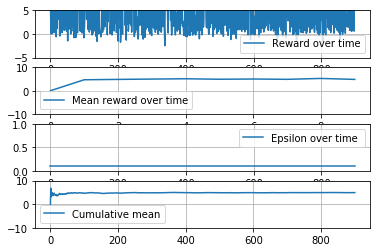

Maximum mean over time :  5.196565758415581


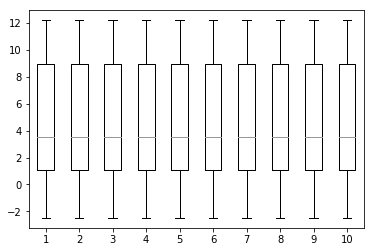

100%|██████████| 999/999 [00:10<00:00, 92.65it/s]


In [21]:
env = C_Bandit.Contextual_bandit()
solver = Q_solver_contextual(env)
solver.run(force_epsilon = 0.1)


# Exercice 4 ; Cartpole and DQN

In [22]:
import gym
from collections import deque
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Add, concatenate, RepeatVector, Flatten, Lambda, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.python.keras.optimizers import Adam
import random

In [23]:
class DQNAgent :
    def __init__(self, env, state_size, action_size) :

        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = 2000)
        self.gamma = 0.995  # discount rate
        self.exploration_rate = 1.  # exploration rate
        self.original_epsilon = 1.
        self.min_epsilon = 0.01
        self.exploration_rate_decay = 150
        self.n_game_max = 300
        self.model = self._build_model()
        self.model.summary()
        np.random.seed(42)

    def _build_model(self) :
        input_state = Input((self.state_size,))
        model = Dense(32, activation = "tanh")(input_state)
        q_value = Dense(self.action_size, activation = "linear")(model)
        dqn = Model([input_state], q_value)
        dqn.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01), loss = "mse")
        return dqn

    def remember(self, state, action, reward, next_state, done) :
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state) :
        if np.random.rand() <= self.exploration_rate :
            return np.random.randint(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_s) :

        input_batch, action_batch, reward_batch, next_state_batch = [], [], [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_s))
        targets = []
        states = []
        for state, action, reward, next_state, done in minibatch :
            # DQN FIT
            vanilla_target = reward
            if not done :
                # Double DQN
                vanilla_target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            vanilla_target_f = self.model.predict(state)
            print(vanilla_target_f.shape)
            vanilla_target_f[state][action] = vanilla_target
            # Train the Neural Net with the state and target_f
            states.append(state[0])
            targets.append(vanilla_target_f[0])
        self.vanillaLoss = self.model.fit(np.array(states), np.array(targets), epochs = 1, verbose = 0).history["loss"][
            0]

    def run(self) :
        done = False
        batch_size = 32
        state = env.reset()
        state = np.reshape(state, (1, self.state_size))
        self.cumulative_reward = 0
        score = []
        epsilon_logger = []
        score_average = []
        cpt_game = 0

        for timer in range(100000) :
            action = self.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, self.state_size))
            self.remember(state, action, reward, next_state, done)

            self.cumulative_reward += reward
            state = next_state
            if done :
                cpt_game += 1
                state = env.reset()
                score_average.append(np.mean(score[-10 :]))
                state = np.reshape(state, (1, self.state_size))
                score.append(self.cumulative_reward)
                print("episode: {}, score: {}, e: {:.2} "
                      .format(cpt_game, self.cumulative_reward, self.exploration_rate))
                self.cumulative_reward = 0
                loss = self.replay(batch_size)
                self.exploration_rate = max(
                    self.exploration_rate - (self.original_epsilon / self.exploration_rate_decay), \
                    self.min_epsilon)
                epsilon_logger.append(self.exploration_rate)
            if timer % 1000 == 0 :
                clear_output(True)
                self.model.summary()
                plt.subplot(311)
                axis = plt.gca()
                axis.set_ylim([0, 200])
                plt.plot(score, label = "Cumulative reward ")
                plt.legend()
                plt.grid()
                plt.show()
                plt.subplot(312)

                axis = plt.gca()
                axis.set_ylim([0, 200])
                plt.plot(score_average, label = "Cumulative Mean reward ")
                plt.legend()
                plt.grid()
                plt.show()
                plt.subplot(313)

                axis = plt.gca()
                axis.set_ylim([0, 1])
                plt.plot(epsilon_logger, label = "Epsilon")
                plt.grid()
                plt.legend()
                plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


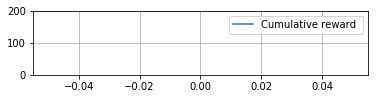

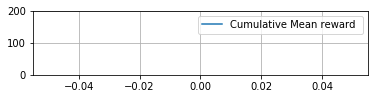

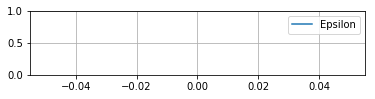

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 1, score: 17.0, e: 1.0 
(1, 2)


IndexError: arrays used as indices must be of integer (or boolean) type

In [24]:

env = gym.make('CartPole-v0')
env.reset()
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

agent_vanilla = DQNAgent(env, state_size, action_size)
agent_vanilla.run()

   

In [ ]:
model = agent_vanilla.model

state = env.reset()
state = np.reshape(state, (1, state_size))
for i in range(2000):

    clear_output(True)
    action = np.argmax(model.predict(state)[0])
    next_st, reward, done, _= env.step(action)
    state = next_st
    if done :
        state = env.reset()
    state = np.reshape(state, (1, state_size))

    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
